### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
import time

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=None, bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    print(a4)
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer())
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 4
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 4
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [7]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            cost_history.append(epoch_cost)
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        elapsed_time = time.time() - start_time
        print("Time elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

Instructions for updating:
Use the retry module or similar alternatives.
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("average_pooling2d/AvgPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7907763 for iteration: 0
Accuracy Test: 0.16111112 on iteration 1
Cost is 1.8044357 for iteration: 1
Accuracy Test: 0.17222223 on iteration 2
Cost is 1.7692106 for iteration: 2
Accuracy Test: 0.16111112 on iteration 3
Cost is 1.7401167 for iteration: 3
Max till now is  0.23888888955116272
Accuracy Test: 0.23888889 on iteration 4
Cost is 1.7319419 for iteration: 4
M

Accuracy Test: 0.85555553 on iteration 85
Cost is 1.1298352 for iteration: 85
Accuracy Test: 0.87777776 on iteration 86
Cost is 1.1330818 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.1214653 for iteration: 87
Accuracy Test: 0.87777776 on iteration 88
Cost is 1.1310997 for iteration: 88
Accuracy Test: 0.8611111 on iteration 89
Cost is 1.1228776 for iteration: 89
Accuracy Test: 0.84444445 on iteration 90
Cost is 1.1159458 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.1232256 for iteration: 91
Accuracy Test: 0.87222224 on iteration 92
Cost is 1.1131374 for iteration: 92
Max till now is  0.8888888955116272
Accuracy Test: 0.8888889 on iteration 93
Cost is 1.1131951 for iteration: 93
Accuracy Test: 0.8666667 on iteration 94
Cost is 1.116449 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.1123483 for iteration: 95
Accuracy Test: 0.87777776 on iteration 96
Cost is 1.1135081 for iteration: 96
Accuracy Test: 0.87777776 on itera

Accuracy Test: 0.89444447 on iteration 188
Cost is 1.0694199 for iteration: 188
Accuracy Test: 0.9 on iteration 189
Cost is 1.068917 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0688443 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.068689 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.0683128 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0682518 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.068166 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0678923 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0677774 for iteration: 196
Accuracy Test: 0.89444447 on iteration 197
Cost is 1.0676211 for iteration: 197
Accuracy Test: 0.89444447 on iteration 198
Cost is 1.0673935 for iteration: 198
Accuracy Test: 0.9 on iteration 199
Cost is 1.067217 for iteration: 199
Accuracy Test: 0.9 on iteration 200
Cost is 1.0671909 for iteration: 200
Accura

Accuracy Test: 0.9111111 on iteration 292
Cost is 1.0610123 for iteration: 292
Accuracy Test: 0.9111111 on iteration 293
Cost is 1.0610033 for iteration: 293
Accuracy Test: 0.9111111 on iteration 294
Cost is 1.060983 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0609691 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.060963 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0609494 for iteration: 297
Accuracy Test: 0.9166667 on iteration 298
Cost is 1.0609363 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0609272 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.060916 for iteration: 300


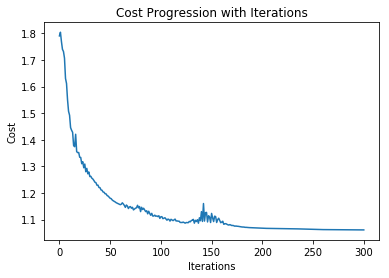

Train Accuracy:  96.86274528503418
Test Accuracy:  92.22221970558167
Max Test Accuracy: 92.22221970558167 on iteration 239
Time elapsed :  5.6258243481318155
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("average_pooling2d/AvgPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7913148 for iteration: 0
Accuracy Test: 0.15 on iteration 1
Cost is 1.8071189 for iteration: 1
Max till now is  0.18888889253139496
Accuracy Test: 0.18888889 on iteration 2
Cost is 1.7702868 for iteration: 2
Max till now is  0.24444444477558136
Accuracy Test: 0.24444444 on iteratio

Accuracy Test: 0.8388889 on iteration 88
Cost is 1.1278864 for iteration: 88
Max till now is  0.8500000238418579
Accuracy Test: 0.85 on iteration 89
Cost is 1.1326824 for iteration: 89
Accuracy Test: 0.84444445 on iteration 90
Cost is 1.1253021 for iteration: 90
Accuracy Test: 0.8333333 on iteration 91
Cost is 1.1217351 for iteration: 91
Max till now is  0.855555534362793
Accuracy Test: 0.85555553 on iteration 92
Cost is 1.1221584 for iteration: 92
Accuracy Test: 0.84444445 on iteration 93
Cost is 1.1187279 for iteration: 93
Accuracy Test: 0.8388889 on iteration 94
Cost is 1.1193863 for iteration: 94
Accuracy Test: 0.85555553 on iteration 95
Cost is 1.1158786 for iteration: 95
Max till now is  0.8611111044883728
Accuracy Test: 0.8611111 on iteration 96
Cost is 1.1161159 for iteration: 96
Accuracy Test: 0.84444445 on iteration 97
Cost is 1.1126298 for iteration: 97
Accuracy Test: 0.85 on iteration 98
Cost is 1.1130384 for iteration: 98
Max till now is  0.8666666746139526
Accuracy Test: 

Max till now is  0.9111111164093018
Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0655991 for iteration: 188
Accuracy Test: 0.90555555 on iteration 189
Cost is 1.0696223 for iteration: 189
Accuracy Test: 0.90555555 on iteration 190
Cost is 1.0645558 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0646179 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0631671 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0626433 for iteration: 193
Accuracy Test: 0.90555555 on iteration 194
Cost is 1.0632087 for iteration: 194
Accuracy Test: 0.9 on iteration 195
Cost is 1.0618289 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0618742 for iteration: 196
Max till now is  0.9166666865348816
Accuracy Test: 0.9166667 on iteration 197
Cost is 1.0620675 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0606049 for iteration: 198
Accuracy Test: 0.89444447 on iteration 199
Cost is 1.0616628 for

Accuracy Test: 0.9111111 on iteration 292
Cost is 1.0542685 for iteration: 292
Accuracy Test: 0.9111111 on iteration 293
Cost is 1.0542324 for iteration: 293
Accuracy Test: 0.9111111 on iteration 294
Cost is 1.054189 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0541353 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.0540682 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.053996 for iteration: 297
Accuracy Test: 0.9111111 on iteration 298
Cost is 1.0539409 for iteration: 298
Accuracy Test: 0.9 on iteration 299
Cost is 1.0539085 for iteration: 299
Accuracy Test: 0.90555555 on iteration 300
Cost is 1.0538954 for iteration: 300


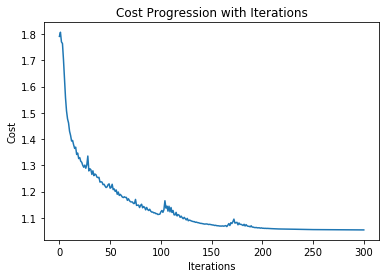

Train Accuracy:  98.03921580314636
Test Accuracy:  90.55555462837219
Max Test Accuracy: 91.66666865348816 on iteration 197
Time elapsed :  5.466703685124715
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("average_pooling2d/AvgPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17222222685813904
Accuracy Test: 0.17222223 on iteration 0
Cost is 1.7910038 for iteration: 0
Max till now is  0.24444444477558136
Accuracy Test: 0.24444444 on iteration 1
Cost is 1.7777611 for iteration: 1
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 2
Cost is 1.8019882 for iteration: 2
Max till now is  0.31666666269302

Accuracy Test: 0.84444445 on iteration 88
Cost is 1.1369812 for iteration: 88
Accuracy Test: 0.8055556 on iteration 89
Cost is 1.135832 for iteration: 89
Accuracy Test: 0.81666666 on iteration 90
Cost is 1.1338396 for iteration: 90
Accuracy Test: 0.85555553 on iteration 91
Cost is 1.1308773 for iteration: 91
Accuracy Test: 0.82222223 on iteration 92
Cost is 1.1372821 for iteration: 92
Accuracy Test: 0.8055556 on iteration 93
Cost is 1.148607 for iteration: 93
Accuracy Test: 0.84444445 on iteration 94
Cost is 1.1337613 for iteration: 94
Accuracy Test: 0.85 on iteration 95
Cost is 1.1403135 for iteration: 95
Accuracy Test: 0.8277778 on iteration 96
Cost is 1.131038 for iteration: 96
Accuracy Test: 0.8388889 on iteration 97
Cost is 1.1400805 for iteration: 97
Accuracy Test: 0.84444445 on iteration 98
Cost is 1.1254886 for iteration: 98
Accuracy Test: 0.8277778 on iteration 99
Cost is 1.1311744 for iteration: 99
Accuracy Test: 0.8388889 on iteration 100
Cost is 1.1312941 for iteration: 100

Accuracy Test: 0.9222222 on iteration 189
Cost is 1.0816774 for iteration: 189
Accuracy Test: 0.9222222 on iteration 190
Cost is 1.0771532 for iteration: 190
Accuracy Test: 0.9222222 on iteration 191
Cost is 1.0747716 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0747576 for iteration: 192
Accuracy Test: 0.9222222 on iteration 193
Cost is 1.0745386 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.0732268 for iteration: 194
Accuracy Test: 0.9 on iteration 195
Cost is 1.0733161 for iteration: 195
Accuracy Test: 0.90555555 on iteration 196
Cost is 1.0725893 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0713145 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0698061 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0698464 for iteration: 199
Accuracy Test: 0.9111111 on iteration 200
Cost is 1.0705885 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.069

Accuracy Test: 0.93333334 on iteration 292
Cost is 1.061104 for iteration: 292
Accuracy Test: 0.93333334 on iteration 293
Cost is 1.0610558 for iteration: 293
Accuracy Test: 0.93333334 on iteration 294
Cost is 1.060998 for iteration: 294
Accuracy Test: 0.93333334 on iteration 295
Cost is 1.0609335 for iteration: 295
Accuracy Test: 0.93333334 on iteration 296
Cost is 1.0608615 for iteration: 296
Accuracy Test: 0.93333334 on iteration 297
Cost is 1.0607951 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.0607342 for iteration: 298
Accuracy Test: 0.93333334 on iteration 299
Cost is 1.0606828 for iteration: 299
Accuracy Test: 0.92777777 on iteration 300
Cost is 1.0606352 for iteration: 300


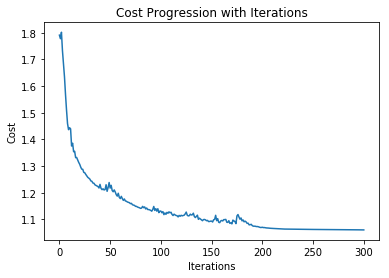

Train Accuracy:  96.76470756530762
Test Accuracy:  92.77777671813965
Max Test Accuracy: 93.33333373069763 on iteration 279
Time elapsed :  5.46291366815567
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("average_pooling2d/AvgPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15000000596046448
Accuracy Test: 0.15 on iteration 0
Cost is 1.7932541 for iteration: 0
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 1
Cost is 1.8012475 for iteration: 1
Accuracy Test: 0.16111112 on iteration 2
Cost is 1.7698058 for iteration: 2
Max till now is  0.23888888955116272
Accuracy Test: 0.23888889 on iteration 3

Accuracy Test: 0.8666667 on iteration 87
Cost is 1.1300043 for iteration: 87
Accuracy Test: 0.84444445 on iteration 88
Cost is 1.1287282 for iteration: 88
Accuracy Test: 0.8388889 on iteration 89
Cost is 1.121452 for iteration: 89
Accuracy Test: 0.84444445 on iteration 90
Cost is 1.1222577 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.1243114 for iteration: 91
Accuracy Test: 0.8611111 on iteration 92
Cost is 1.1397812 for iteration: 92
Accuracy Test: 0.85555553 on iteration 93
Cost is 1.1482213 for iteration: 93
Accuracy Test: 0.87222224 on iteration 94
Cost is 1.130033 for iteration: 94
Accuracy Test: 0.84444445 on iteration 95
Cost is 1.1221726 for iteration: 95
Accuracy Test: 0.85555553 on iteration 96
Cost is 1.1318991 for iteration: 96
Accuracy Test: 0.8611111 on iteration 97
Cost is 1.1255882 for iteration: 97
Max till now is  0.8777777552604675
Accuracy Test: 0.87777776 on iteration 98
Cost is 1.132445 for iteration: 98
Accuracy Test: 0.8666667 on iteratio

Accuracy Test: 0.9222222 on iteration 189
Cost is 1.0749227 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0740256 for iteration: 190
Accuracy Test: 0.9166667 on iteration 191
Cost is 1.0732565 for iteration: 191
Accuracy Test: 0.9166667 on iteration 192
Cost is 1.0731173 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.072312 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0717388 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0712895 for iteration: 195
Accuracy Test: 0.9166667 on iteration 196
Cost is 1.0708318 for iteration: 196
Accuracy Test: 0.9166667 on iteration 197
Cost is 1.0702999 for iteration: 197
Accuracy Test: 0.9222222 on iteration 198
Cost is 1.0691705 for iteration: 198
Accuracy Test: 0.92777777 on iteration 199
Cost is 1.0686144 for iteration: 199
Accuracy Test: 0.9222222 on iteration 200
Cost is 1.0682279 for iteration: 200
Accuracy Test: 0.9166667 on iteration 201
Cost is 1.

Accuracy Test: 0.93333334 on iteration 292
Cost is 1.0573411 for iteration: 292
Accuracy Test: 0.93333334 on iteration 293
Cost is 1.0573294 for iteration: 293
Accuracy Test: 0.92777777 on iteration 294
Cost is 1.0573165 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0573009 for iteration: 295
Accuracy Test: 0.92777777 on iteration 296
Cost is 1.0572866 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0572765 for iteration: 297
Accuracy Test: 0.92777777 on iteration 298
Cost is 1.0572659 for iteration: 298
Accuracy Test: 0.92777777 on iteration 299
Cost is 1.0572534 for iteration: 299
Accuracy Test: 0.92777777 on iteration 300
Cost is 1.0572433 for iteration: 300


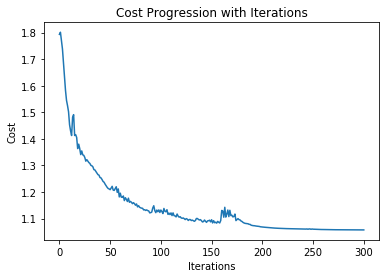

Train Accuracy:  97.35293984413147
Test Accuracy:  92.77777671813965
Max Test Accuracy: 93.33333373069763 on iteration 203
Time elapsed :  5.987495581309001
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
5
Tensor("max_pooling2d/MaxPool:0", shape=(?, 28, 28, 8), dtype=float32)
 pad 0 f 4 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("average_pooling2d/AvgPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1296), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.20555555820465088
Accuracy Test: 0.20555556 on iteration 0
Cost is 1.7945929 for iteration: 0
Accuracy Test: 0.18333334 on iteration 1
Cost is 1.7843533 for iteration: 1
Max till now is  0.21666666865348816
Accuracy Test: 0.21666667 on iteration 2
Cost is 1.7557626 for iteration: 2
Max till now is  0.28333333134651184
Accuracy Test: 0.28333333 on ite

Max till now is  0.894444465637207
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.1405932 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.1440501 for iteration: 86
Accuracy Test: 0.81666666 on iteration 87
Cost is 1.1415553 for iteration: 87
Accuracy Test: 0.8333333 on iteration 88
Cost is 1.1361002 for iteration: 88
Accuracy Test: 0.87222224 on iteration 89
Cost is 1.1458188 for iteration: 89
Accuracy Test: 0.87222224 on iteration 90
Cost is 1.1538541 for iteration: 90
Max till now is  0.8999999761581421
Accuracy Test: 0.9 on iteration 91
Cost is 1.1666898 for iteration: 91
Accuracy Test: 0.85555553 on iteration 92
Cost is 1.1410804 for iteration: 92
Accuracy Test: 0.79444444 on iteration 93
Cost is 1.1362207 for iteration: 93
Accuracy Test: 0.8833333 on iteration 94
Cost is 1.1524085 for iteration: 94
Accuracy Test: 0.9 on iteration 95
Cost is 1.1480378 for iteration: 95
Accuracy Test: 0.87777776 on iteration 96
Cost is 1.1421874 for iteration: 96
Accuracy 

Accuracy Test: 0.9 on iteration 191
Cost is 1.075815 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.075622 for iteration: 192
Accuracy Test: 0.9 on iteration 193
Cost is 1.0754415 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.075274 for iteration: 194
Accuracy Test: 0.9 on iteration 195
Cost is 1.0751137 for iteration: 195
Accuracy Test: 0.90555555 on iteration 196
Cost is 1.0749592 for iteration: 196
Accuracy Test: 0.9 on iteration 197
Cost is 1.0748107 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0746666 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0745255 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0743936 for iteration: 200
Accuracy Test: 0.90555555 on iteration 201
Cost is 1.0742602 for iteration: 201
Accuracy Test: 0.90555555 on iteration 202
Cost is 1.0741231 for iteration: 202
Accuracy Test: 0.90555555 on iteration 203
Cost is 1.0739745 for iteration: 203
Max t

Accuracy Test: 0.9166667 on iteration 295
Cost is 1.067331 for iteration: 295
Accuracy Test: 0.9166667 on iteration 296
Cost is 1.0673133 for iteration: 296
Accuracy Test: 0.9166667 on iteration 297
Cost is 1.0672978 for iteration: 297
Accuracy Test: 0.9166667 on iteration 298
Cost is 1.0672824 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0672684 for iteration: 299
Accuracy Test: 0.9166667 on iteration 300
Cost is 1.067254 for iteration: 300


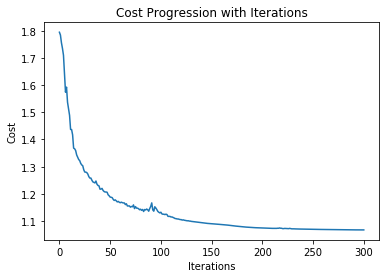

Train Accuracy:  95.98039388656616
Test Accuracy:  91.66666865348816
Max Test Accuracy: 91.66666865348816 on iteration 219
Time elapsed :  5.578462934494018


In [8]:
for learning_rate in [0.1, 0.01, 0.05, 0.09, 0.11]:
    train_cnn_lenet5(300, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, 0.01, 0.8)

### 5. (20pts) Predictions